In [1]:
## Imports the required libraries 

from scipy.stats import chi2 as chi2_scp
from sklearn.decomposition import PCA
from cosmopower import cosmopower_NN
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
from numpy.linalg import inv
import tensorflow as tf
import numpy as np
import emcee
import gc

# Sets a random seed for reproducible results 
np.random.seed(100)

In [2]:
## Loads-in all required data 

reference_model = np.load("reference_model.npy")
parameters = np.load("parameters.npz") 
cov = np.load("covariance.npy")
models = np.load("models.npy")

# Restores the trained model 
cp_nn_model = cosmopower_NN(restore = True, restore_filename = "emulator_final")
train_sample = np.arange(0, 7000)
# Selects 7000 rows from our model data for training 
train_features = np.load("models.npy")[train_sample]
minimum = np.min(train_features, axis = 0)
maximum = np.max(train_features - minimum, axis = 0)

In [3]:
list(parameters.keys())

['omega_m', 'omega_b', 'As', 'w']

The following cell does the PCA data compression:

In [4]:
# Computes the mean of our models for each column. This will be subtracted from "models" for numerical 
# stability
mean = np.mean(models, axis = 0) 
# Defines the number of PCA eigenvalues 
N_pca = 100
# Performs the dimensionality reduction 
pca = PCA(n_components = N_pca, svd_solver = "full")
# Performs the PCA fitting 
models_pca = pca.fit_transform(models - mean) 
# Rotates the covariance matrix 
rotation_matrix = pca.components_.T
# Computes the PCA covariance matrix 
cov_pca = np.matmul(rotation_matrix.T, np.matmul(cov, rotation_matrix))
cov_pca_inv = inv(cov_pca)

In [5]:
# Specifies the length of the MCMC chain 
nsteps = 5000  
# Specifies the number of walkers in the MCMC chain 
nwalkers = 35
# Specifies the number of dimensions (4 since we are varying 4 parameters)
ndim = 4

## Computes various parameter values 

omega_m_vals = parameters["omega_m"]
omega_b_vals = parameters["omega_b"]
As_vals = parameters["As"]
w_vals = parameters["w"]

## Specifies prior bounds for all parameters

omega_m_bounds = [min(omega_m_vals), max(omega_m_vals)]
omega_b_bounds = [min(omega_b_vals), max(omega_b_vals)]
As_bounds = [min(As_vals), max(As_vals)]
w_bounds = [min(w_vals), max(w_vals)]
bounds = [omega_m_bounds, omega_b_bounds, As_bounds, w_bounds]

# Initiates an array that will contain different starting positions 
pos = np.empty((nwalkers, ndim))

for i in range(ndim):
    # Computes positions within a prior range according to a uniform distribution 
    vals = np.random.uniform(bounds[i][0], bounds[i][1], nwalkers)
    pos[:, i] = vals
    
def log_probability(theta):
    """
    Computes the log probability of certain parameter combinations. 
    """
    
    omega_m, omega_b, As, w = theta 
    
    # Checks if the parameter values are within their prior ranges 
    if omega_m_bounds[0] < omega_m < omega_m_bounds[1] and omega_b_bounds[0] < omega_b < omega_b_bounds[1] and As_bounds[0] < As < As_bounds[1] and w_bounds[0] < w < w_bounds[1]:
        
        # Makes a dictionary of parameter values 
        params = {"omega_m": [omega_m], "omega_b": [omega_b], "As": [As], "w": [w]}
        
        # Predicts the output of this parameter combination using the emulator 
        pred_vector = cp_nn_model.predictions_np(params)[0]
        pred_vector = pred_vector * maximum + minimum
        delta = pred_vector - reference_model
        # Applies a dimensionality reduction to delta 
        delta = (pca.transform([delta])).flatten()
        # Compues the log probability, which is -chi^2 / 2
        likelihood = -0.5 * np.matmul(delta, np.matmul(cov_pca_inv, delta))
        return likelihood
    
    # If a parameter is outside its prior range, then the log probability is - infinity 
    else: 
        return -np.inf 

In [6]:
# Initializes the walkers 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# Runs the MCMC 
sampler.run_mcmc(pos, nsteps, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:11<00:00,  7.45it/s]


State([[ 3.49800814e-01  4.50211502e-02  2.01704070e-09 -1.12913090e+00]
 [ 3.55781472e-01  4.40757614e-02  1.93317385e-09 -1.12384259e+00]
 [ 3.50113629e-01  4.44879120e-02  1.98417080e-09 -1.14459272e+00]
 [ 3.40912128e-01  4.01162670e-02  1.97144068e-09 -1.19242822e+00]
 [ 3.52284152e-01  4.35049937e-02  1.94888000e-09 -1.14487127e+00]
 [ 3.54930602e-01  4.67542294e-02  1.99891000e-09 -1.11610653e+00]
 [ 3.46966366e-01  4.25333222e-02  1.96471317e-09 -1.19959140e+00]
 [ 3.49611917e-01  4.81226962e-02  2.06848210e-09 -1.15745052e+00]
 [ 3.42772571e-01  4.58874088e-02  2.07694807e-09 -1.20515649e+00]
 [ 3.46348162e-01  4.74117971e-02  2.09148772e-09 -1.17021559e+00]
 [ 3.49417324e-01  4.19445055e-02  1.93093796e-09 -1.14405104e+00]
 [ 3.50731922e-01  4.47484317e-02  2.00664991e-09 -1.11110496e+00]
 [ 3.52260781e-01  4.88383551e-02  2.05772974e-09 -1.16751080e+00]
 [ 3.53711434e-01  4.26995435e-02  1.91900522e-09 -1.14378893e+00]
 [ 3.42646766e-01  4.07371806e-02  1.96555749e-09 -1.169

In [7]:
print("Mean acceptance fraction:", sampler.acceptance_fraction)
# Computes the autocorrelation time 
tau = sampler.get_autocorr_time(tol = 0)
print("Autocorrelation time:", tau) 
# Retrieves the parameter values for each walker at each step 
samples = sampler.get_chain()

Mean acceptance fraction: [0.598  0.5896 0.6012 0.5778 0.593  0.6044 0.5806 0.5894 0.5886 0.5866
 0.5926 0.5922 0.59   0.6082 0.5924 0.5878 0.594  0.5904 0.586  0.5942
 0.5942 0.5882 0.5946 0.5908 0.587  0.5864 0.591  0.5998 0.5964 0.5882
 0.5838 0.585  0.598  0.5868 0.595 ]
Autocorrelation time: [34.06957357 45.20397574 42.34357364 38.31307517]


Text(0.5, 0, 'Step Number')

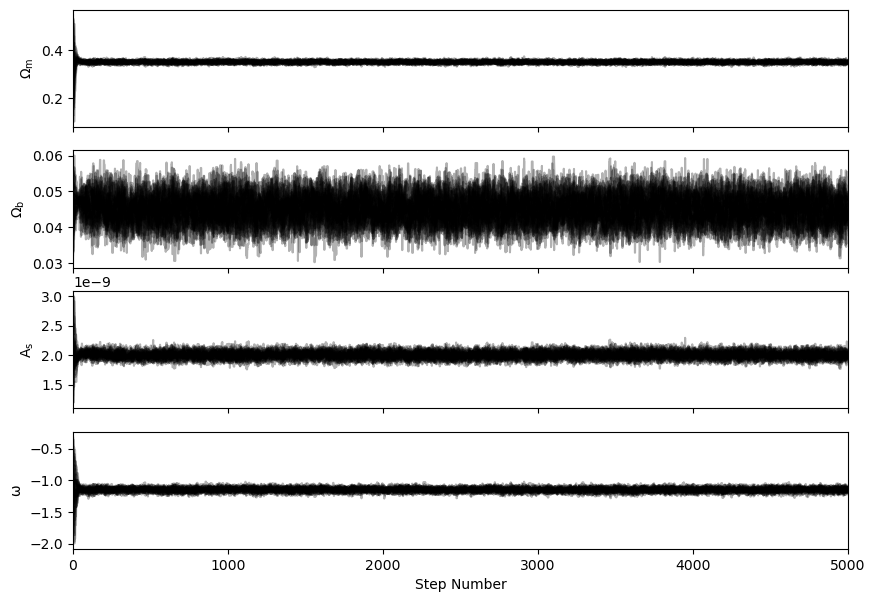

In [8]:
## Plots the parameter values for each walker at each step 

labels = [r"$\mathrm{\Omega_m}$", r"$\mathrm{\Omega_b}$", r"$\mathrm{A_s}$", 
          r"$\mathrm{\omega}$"]
fig, axes = plt.subplots(4, figsize = (10, 7), sharex = True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step Number")

Removed no burn in


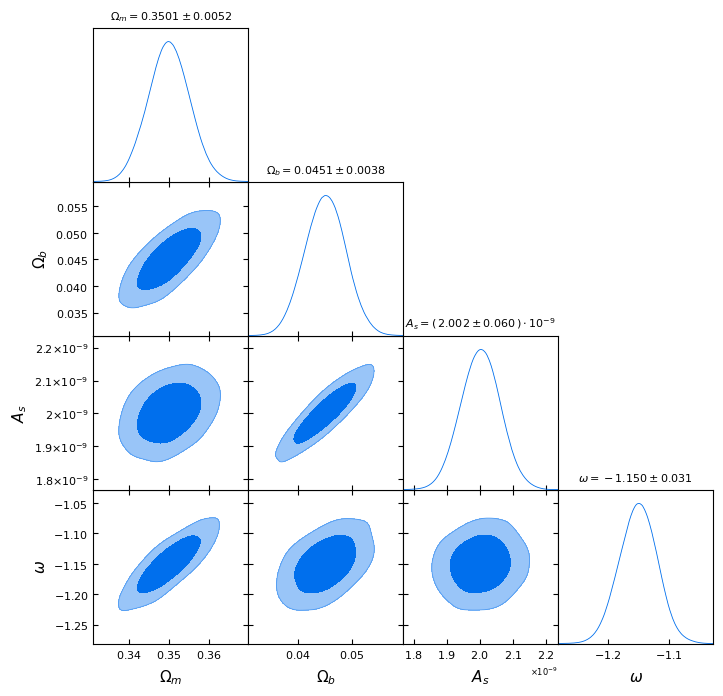

In [9]:
# Discards the burn-in steps, thins the chain, and flattens it 
flat_samples = sampler.get_chain(discard = 200, thin = 25, flat = True) 

## Plots the posterior probability distributions 

names = ["\Omega_m", "\Omega_b", "A_s", "\omega"]
samples = MCSamples(samples = flat_samples, names = names, labels = names)
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled = True, title_limit = 1)

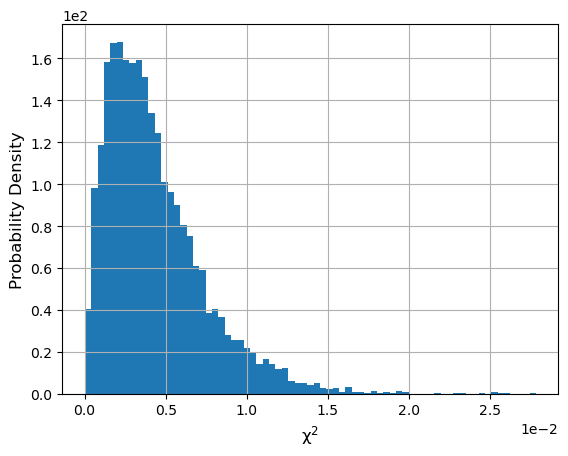

In [10]:
# Retrieves the log probabilities from the chain 
log_prob_samples = sampler.get_log_prob(discard = 200, thin = 25, flat = True)
# Computes the chi-squared values from the log probabilities 
chi2 = -2 * log_prob_samples
# Computes the degrees of freedom (dof)
dof = len(reference_model) - 1

## Plots the reduced chi-squared distrubution 

plt.hist(chi2 / dof, bins = "fd", density = True, color = "tab:blue")
plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
plt.ylabel("Probability Density", fontsize = 12)
plt.ticklabel_format(axis = "both", style = "sci", scilimits = (0, 0))
plt.grid()
plt.show()

In [11]:
np.save("Q4_100_flat_samples.npy", flat_samples)
np.save("Q4_100_log_prob_samples.npy", log_prob_samples)